In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [47]:
SqlInjectionData = pd.read_csv('SQLiV3.csv')
SqlInjectionDat_2 = pd.read_csv('Modified_SQL_Dataset.csv')
XssDataset = pd.read_csv('XSS_dataset.csv')

In [48]:
XssDataset = XssDataset.drop(["Unnamed: 0"], axis=1)
XssDataset = XssDataset.astype(str)
XssDataset = XssDataset.dropna()
XssDataset=XssDataset[XssDataset.Label.apply(lambda x:x.isnumeric())]

In [49]:
SIData=SqlInjectionData.drop(["Unnamed: 2","Unnamed: 3"],axis=1)

In [50]:
SIData=SIData.dropna()
SqlInjectionDat_2.dropna()
SqlInjectionDat_2 = SqlInjectionDat_2.rename(columns={"Query":"Sentence"})
SqlInjectionDat_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30919 entries, 0 to 30918
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  30919 non-null  object
 1   Label     30919 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 483.2+ KB


In [51]:
#добавление доп данных в датасет
payloads = []
for name in ["quick-SQLi.txt", "Generic-BlindSQLi.fuzzdb.txt", "Generic-SQLi.txt"]:
    data = open(name, "r").readlines()
    payloads = payloads + data
Dataset = pd.DataFrame({'Sentence':payloads, 'Label':[1]*len(payloads)})
Dataset["Label"] = Dataset["Label"].astype(str)
SqlInjectionDat_2["Label"] = SqlInjectionDat_2["Label"].astype(str)
SIData = pd.concat([SIData, Dataset, SqlInjectionDat_2], ignore_index=True)


In [52]:
SIData['Label'] = SIData['Label'].astype(str)
SIData=SIData[SIData.Label.apply(lambda x:x.isnumeric())]

In [53]:
# Split the dataset into train data
trainSentences, testSentences, trainLabels, testpLabels = train_test_split(SIData["Sentence"], SIData['Label'], test_size=0.3, random_state=42)
trainSentences_XSS, testSentences_XSS, trainLabels_XSS, testpLabels_XSS = train_test_split(XssDataset["Sentence"], XssDataset['Label'], test_size=0.3, random_state=42)

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
feature_extraction=TfidfVectorizer(min_df=1,stop_words='english', lowercase=True)
feature_extraction_XSS=TfidfVectorizer(min_df=1,stop_words='english', lowercase=True)

In [55]:
import pickle as p
xTrainFeature=feature_extraction.fit_transform(trainSentences)
xTrainFeature_XSS = feature_extraction_XSS.fit_transform(trainSentences_XSS)
filename="Vectorizer.pkl"
filename_XSS ="Vectorizer_XSS.pkl"
# with open(filename, "wb") as file:
#     p.dump(feature_extraction, file)
with open(filename_XSS, "wb") as file:
    p.dump(feature_extraction_XSS, file)

In [56]:
XTestFeatures=feature_extraction.transform(testSentences)
XTestFeatures_XSS=feature_extraction_XSS.transform(testSentences_XSS)
XTestFeatures_XSS

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 34727 stored elements and shape (4106, 8823)>

In [57]:
Y_train = trainLabels.astype('int')
Y_test = testpLabels.astype('int')
Y_train_XSS = trainLabels_XSS.astype('int')
Y_test_XSS = testpLabels_XSS.astype('int')


**RandomForestClassifier**

In [29]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier()

In [30]:
model.fit(xTrainFeature, Y_train)

RandomForestClassifier()

In [31]:
predictionTraining= model.predict(xTrainFeature)
accuracyTraining= accuracy_score(Y_train, predictionTraining)
accuracyTraining

0.9987094395280236

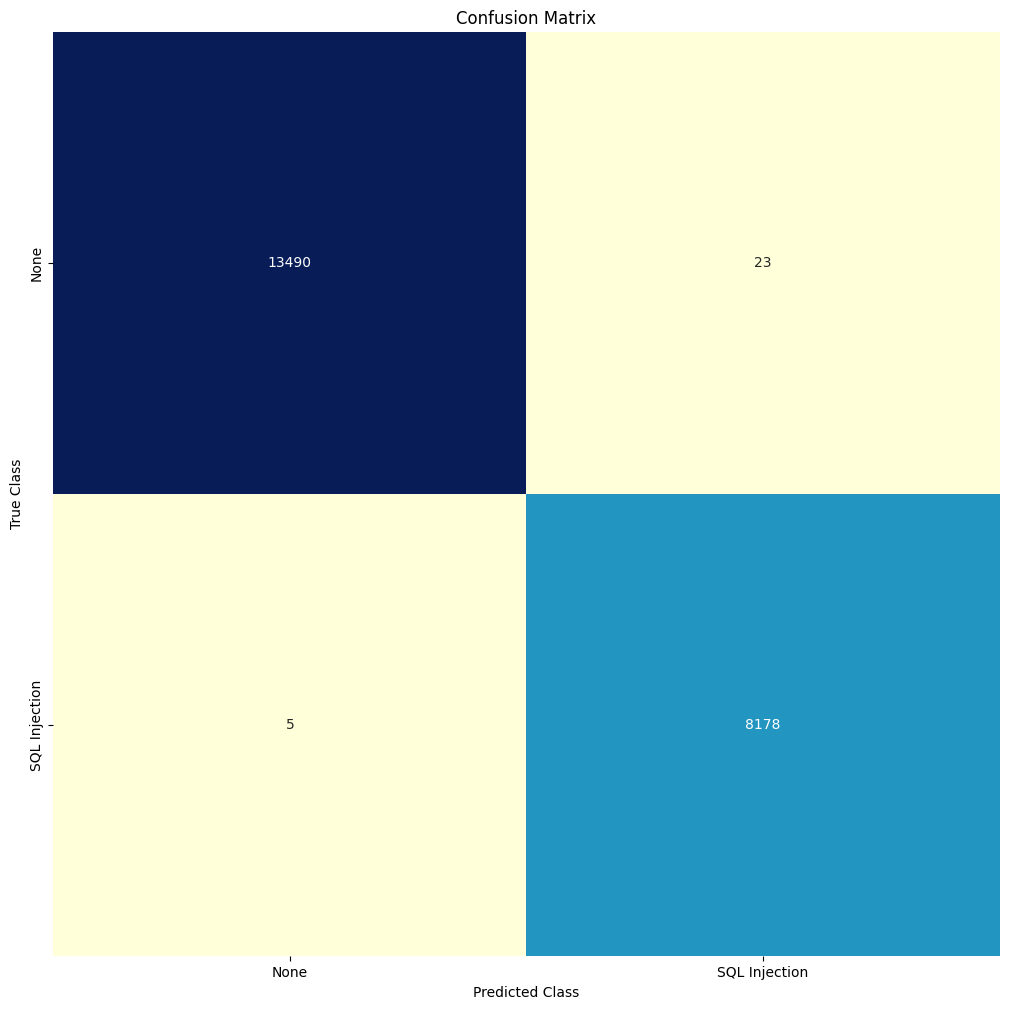

In [32]:
import seaborn as sn
confusion_matrixTraining= confusion_matrix(Y_train, predictionTraining)
confusion_matrixTraining
# Create a DataFrame for the confusion matrix
df_cm = pd.DataFrame(confusion_matrixTraining, index=['None', 'SQL Injection'],
                     columns=['None', 'SQL Injection'])

# Create the confusion matrix plot using seaborn
plt.figure(figsize=(10, 10))
sn.heatmap(df_cm, annot=True, cbar=None, cmap="YlGnBu", fmt="d")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

In [33]:
from sklearn.metrics import classification_report
classification_report=classification_report(Y_train, predictionTraining)
print(classification_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13513
           1       1.00      1.00      1.00      8183

    accuracy                           1.00     21696
   macro avg       1.00      1.00      1.00     21696
weighted avg       1.00      1.00      1.00     21696



In [34]:
predictionTesting= model.predict(XTestFeatures)
accuracyTesting= accuracy_score(Y_test, predictionTesting)
accuracyTesting

0.7673943434777933

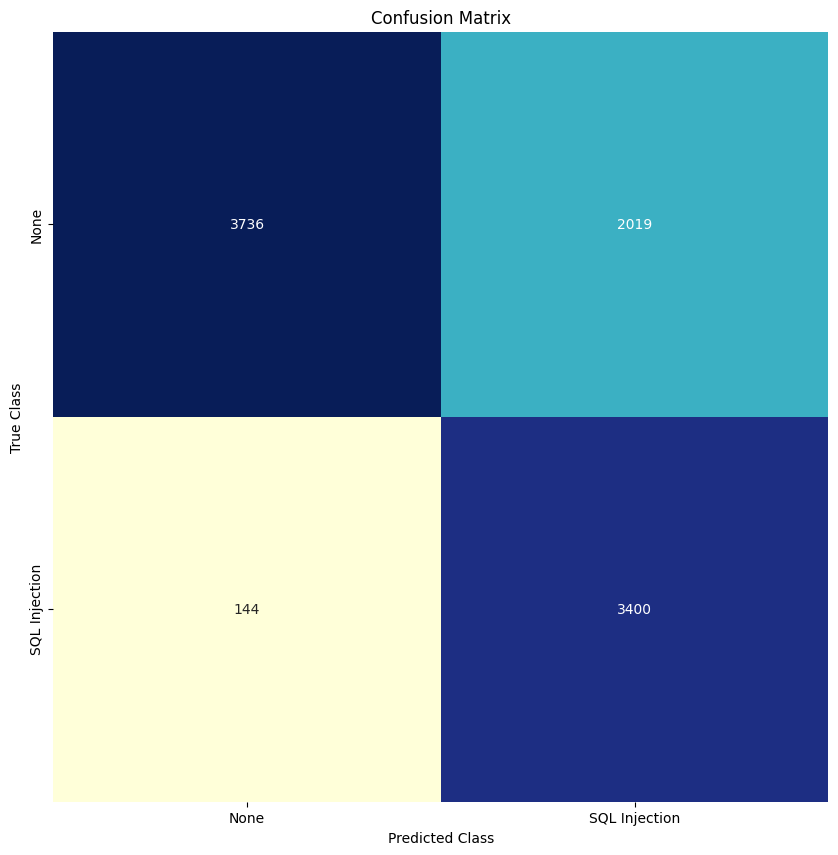

In [35]:
confusion_matrixTesting= confusion_matrix(Y_test, predictionTesting)
confusion_matrixTesting
df_cm = pd.DataFrame(confusion_matrixTesting, index=['None', 'SQL Injection'],
                     columns=['None', 'SQL Injection'])

# Create the confusion matrix plot using seaborn
plt.figure(figsize=(10, 10))
sn.heatmap(df_cm, annot=True, cbar=None, cmap="YlGnBu", fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

In [36]:
from sklearn.metrics import classification_report
classification_report=classification_report(Y_test, predictionTesting)
print(classification_report)

              precision    recall  f1-score   support

           0       0.96      0.65      0.78      5755
           1       0.63      0.96      0.76      3544

    accuracy                           0.77      9299
   macro avg       0.80      0.80      0.77      9299
weighted avg       0.84      0.77      0.77      9299



In [37]:
input_sqlInjection = ["AND 1 = utl_inaddr.get_host_address ( ..."]
# convert text to feature vectors
input_data_features = feature_extraction.transform(input_sqlInjection)
# making prediction
prediction = model.predict(input_data_features)
if (prediction[0]==0):
    print('Ham sqlInjection')
else:
    print('Spam sqlInjection')

Spam sqlInjection


In [38]:
input_sqlInjection1 = ["SELECT TOP 3 * FROM race"]
# convert text to feature vectors
input_data_features1 = feature_extraction.transform(input_sqlInjection1)
# making prediction
prediction1 = model.predict(input_data_features1)
if (prediction1[0]==0):
    print('Ham sqlInjection')
else:
    print('Spam sqlInjection')

Ham sqlInjection


In [39]:
import pickle as p
filename="SqlInjectionRF.h5"
with open(filename, "wb") as file:
    p.dump(model,file)

**Desicion Tree**

In [40]:
from sklearn.tree import DecisionTreeClassifier

In [41]:
mod=DecisionTreeClassifier()
mod.fit(xTrainFeature, Y_train)

DecisionTreeClassifier()

In [42]:
predictionTrain1= mod.predict(xTrainFeature)
accuracyTrain= accuracy_score(Y_train, predictionTrain1)
accuracyTrain

0.9989398967551623

In [43]:
predictionTest1= mod.predict(XTestFeatures)
accuracyTest= accuracy_score(Y_test, predictionTest1)
accuracyTest

0.7671792665878051

In [44]:
import pickle as p
filename="SqlInjectionTREE.pkl"
with open(filename, "wb") as file:
    p.dump(model,file)

**LogisticRegression***

In [58]:
from sklearn.linear_model import LogisticRegression
model1=LogisticRegression()
model2=LogisticRegression()
model1.fit(xTrainFeature, Y_train)
model2.fit(xTrainFeature_XSS, Y_train_XSS)

LogisticRegression()

In [59]:
predictionTraining1= model1.predict(xTrainFeature)
accuracyTraining1= accuracy_score(Y_train, predictionTraining1)
predictionTraining2 = model2.predict(xTrainFeature_XSS)
accuracyTraining2= accuracy_score(Y_train_XSS, predictionTraining2)
accuracyTraining2

0.997286012526096

In [60]:
predictionTesting1= model1.predict(XTestFeatures)
accuracyTesting1= accuracy_score(Y_test, predictionTesting1)
predictionTesting2= model2.predict(XTestFeatures_XSS)
accuracyTesting2= accuracy_score(Y_test_XSS, predictionTesting2)

0.995859717486605

In [61]:
import pickle as p
filename="XSSInjectionLR.pkl"
with open(filename, "wb") as file:
    p.dump(model2,file)

In [40]:
def transorm_and_predict(data, model):
    data = feature_extraction_XSS.transform(data)
    return model.predict(data)

print(transorm_and_predict([""], model2))

[1]


**SUPPORT VECTOR MACHINES**

In [51]:
from sklearn.svm import SVC
model2=SVC()
model2.fit(xTrainFeature, Y_train)

KeyboardInterrupt: 

In [196]:
predictionTraining2= model2.predict(xTrainFeature)
accuracyTraining2= accuracy_score(Y_train, predictionTraining2)
accuracyTraining2

0.9961744100294986

In [197]:
predictionTesting2= model2.predict(XTestFeatures)
accuracyTesting2= accuracy_score(Y_test, predictionTesting2)
accuracyTesting2

0.7710506506075923

In [2]:
import pickle as p
filename="SqlInjectionSVM.pkl"
with open(filename, "wb") as file:
    p.dump(model,file)

NameError: name 'model' is not defined

**naive bayes**

In [1]:
xTrainFeature2=feature_extraction.fit_transform(trainSentences).toarray()

from sklearn.naive_bayes import GaussianNB
model3=GaussianNB()
model3.fit(xTrainFeature2, Y_train)

NameError: name 'feature_extraction' is not defined

In [50]:
predictionTraining3= model3.predict(xTrainFeature2)
accuracyTraining3= accuracy_score(Y_train, predictionTraining3)
accuracyTraining3

0.9882385886306356

In [51]:
XTestFeatures1 = feature_extraction.transform(testSentences).toarray()
predictionTesting3= model3.predict(XTestFeatures1)
accuracyTesting3= accuracy_score(Y_test, predictionTesting3)
accuracyTesting3

0.7927692475225961

In [52]:
import pickle as p
filename="SqlInjectionGaussianNB.pkl"
with open(filename, "wb") as file:
    p.dump(model,file)